# WeatherClock Utils

Author: [@Zhao-Zehua](https://github.com/Zhao-Zehua)

## Environment Setup

In [ ]:
%pip install Pillow matplotlib requests

## Icon

### Convert Image to .h Format

In [1]:
import io
import os
from PIL import Image

def image_to_h(
    image_path: str, 
    resolution: tuple = (18, 18),  # Default resolution (18x18)
    background: tuple = (0, 0, 0)  # Default background color for transparency (black in RGB format)
):
    """
    Convert an image (PNG or JPG) to a C/C++ header file containing a uint8_t array of JPEG data.
    
    This function intelligently resizes the image, handles transparency, and generates code with the highest quality.
    Output path and array name are automatically derived from the input image filename.
    
    :param image_path: Path to the input image (e.g., 'logo.png').
    :param resolution: A tuple (width, height) representing the target resolution (e.g., (18, 18)).
    :param background: An RGB tuple (r, g, b) to fill transparent areas in PNG (e.g., (0, 0, 0) for black).
    """
    # Extract basename and generate output path and array name
    basename = os.path.basename(image_path)
    file_name, _ = os.path.splitext(basename)
    output_path = os.path.join(os.path.dirname(image_path), file_name + ".h")
    array_name = file_name
    
    print(f"--- Starting conversion for '{image_path}' ---")
    print(f"Output file: '{output_path}', Array name: '{array_name}'")
    
    try:
        # 1. Open the image
        with Image.open(image_path) as img:
            print(f"Successfully opened image. Original mode: {img.mode}, Original resolution: {img.size}")

            # 2. Check and adjust resolution if needed
            target_width, target_height = resolution
            if img.size != resolution:
                print(f"Resizing image from {img.size} to {resolution}...")
                # Use LANCZOS for best downsampling quality
                img = img.resize(resolution, Image.Resampling.LANCZOS)
            else:
                print("Image resolution matches target. No resize needed.")

            # 3. Handle transparency and ensure RGB mode
            if img.mode == 'RGBA':
                print(f"Detected transparent PNG. Filling background with color {background}...")
                # Create a background with the specified color
                bg_image = Image.new('RGB', img.size, background)
                # Paste using the PNG's alpha channel as a mask
                bg_image.paste(img, mask=img.split()[3])
                img = bg_image
            elif img.mode != 'RGB':
                print(f"Converting image from mode '{img.mode}' to 'RGB'...")
                img = img.convert('RGB')

            # 4. Compress as JPEG with quality=100 and get byte data
            print("Converting to JPEG format (quality=100)...")
            with io.BytesIO() as byte_stream:
                img.save(byte_stream, format='JPEG', quality=100)
                image_bytes = byte_stream.getvalue()
            
            print(f"JPEG conversion complete. Data size: {len(image_bytes)} bytes.")

            # 5. Generate C/C++ header file content
            print(f"Generating C array with name '{array_name}'...")
            
            header_comments = f"// Generated from '{image_path}'\n"
            header_comments += f"// Target Resolution: {target_width}x{target_height}\n"
            header_comments += f"// Format: JPEG (Quality 100) as uint8_t byte array\n\n"
            
            c_code = header_comments
            c_code += "#include <pgmspace.h>\n\n"
            c_code += f"const uint8_t {array_name}[] PROGMEM = {{\n"
            
            # Format byte array
            line_byte_count = 0
            for i, byte in enumerate(image_bytes):
                if line_byte_count == 0:
                    c_code += "  "  # Indentation at the beginning of line
                
                c_code += f'0x{byte:02x}, '
                line_byte_count += 1
                
                # Line break every 15 bytes, but not after the last byte
                if line_byte_count >= 15 and i < len(image_bytes) - 1:
                    c_code += '\n'
                    line_byte_count = 0
            
            # Clean up any trailing comma and space
            if c_code.endswith(', '):
                c_code = c_code[:-2]

            c_code += "\n};"
        
            # 6. Write to the target file
            with open(output_path, 'w') as f:
                f.write(c_code)

            print(f"\n✅ Success! File '{output_path}' has been created.")
            print("-" * 50)

    except FileNotFoundError:
        print(f"❌ Error: Input file not found at '{image_path}'")
        print("-" * 50)
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")
        print("-" * 50)

# Example usage

image_to_h(
    image_path='./img/chem_5120.png', 
    resolution=(18, 18), 
    background=(0, 0, 0)
)

--- Starting conversion for './img/chem_5120.png' ---
Output file: './img\chem_5120.h', Array name: 'chem_5120'
Successfully opened image. Original mode: RGBA, Original resolution: (5120, 5120)
Resizing image from (5120, 5120) to (18, 18)...
Detected transparent PNG. Filling background with color (0, 0, 0)...
Converting to JPEG format (quality=100)...
JPEG conversion complete. Data size: 1247 bytes.
Generating C array with name 'chem_5120'...

✅ Success! File './img\chem_5120.h' has been created.
--------------------------------------------------


### Preview .h Image

--- Reading and displaying './img/chem_5120.h' ---
Image resolution: 18x18
Extracted 1247 bytes of image data from file
Image format: JPEG
Image mode: RGB
Actual size: (18, 18)


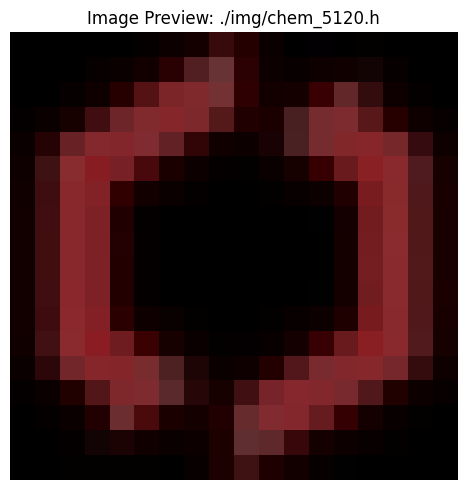

✅ Image displayed successfully
--------------------------------------------------


In [2]:
import io
import re
from PIL import Image
import matplotlib.pyplot as plt

def preview_h_image(h_file_path: str):
    """
    Read and display images from .h files generated by image_to_h function
    
    :param h_file_path: Path to the .h file
    """
    print(f"--- Reading and displaying '{h_file_path}' ---")
    
    try:
        # 1. Read file content
        with open(h_file_path, 'r') as f:
            content = f.read()
        
        # 2. Extract metadata
        resolution_match = re.search(r'// Target Resolution: (\d+)x(\d+)', content)
        if resolution_match:
            width, height = int(resolution_match.group(1)), int(resolution_match.group(2))
            print(f"Image resolution: {width}x{height}")
        else:
            print("Warning: Could not find resolution information in file")
        
        # 3. Extract byte data
        # Find all hexadecimal values in array definition
        byte_pattern = r'0x[0-9a-fA-F]{2}'
        hex_bytes = re.findall(byte_pattern, content)
        
        if not hex_bytes:
            print("❌ Error: No image data found in file")
            return
        
        # Convert hex strings to bytes
        image_bytes = bytes([int(hb, 16) for hb in hex_bytes])
        print(f"Extracted {len(image_bytes)} bytes of image data from file")
        
        # 4. Create image from byte data
        with io.BytesIO(image_bytes) as byte_stream:
            img = Image.open(byte_stream)
            
            # 5. Display image info
            print(f"Image format: {img.format}")
            print(f"Image mode: {img.mode}")
            print(f"Actual size: {img.size}")
            
            # 6. Display the image
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(f"Image Preview: {h_file_path}")
            plt.tight_layout()
            plt.show()
            
            print("✅ Image displayed successfully")
            print("-" * 50)
    
    except FileNotFoundError:
        print(f"❌ Error: File not found '{h_file_path}'")
        print("-" * 50)
    except Exception as e:
        print(f"❌ Error occurred: {e}")
        print("-" * 50)

# Example usage
preview_h_image("./img/chem_5120.h")

## Color

### Convert RGB Hex to 16-bit Color

In [3]:
def rgbhex_to_16bit(hex: str) -> str:
    """
    Convert RGB hexadecimal color value to 16-bit color format (RGB565).
    
    This function takes a standard RGB hex color code and converts it to the 16-bit RGB565 format
    commonly used in embedded displays. RGB565 uses 5 bits for red, 6 bits for green, and 5 bits for blue.
    
    :param hex: RGB color in hexadecimal string (e.g., '#94070A' or '94070A')
    :return: 16-bit color format in hexadecimal string (e.g., '0x9021')
    """
    # Remove # prefix if present
    if hex.startswith('#'):
        hex = hex[1:]
    
    # Extract R, G, B values from hexadecimal string
    r = int(hex[0:2], 16)
    g = int(hex[2:4], 16)
    b = int(hex[4:6], 16)
    
    # Convert to 16-bit color format (RGB565)
    # (r & 0xF8) keeps 5 most significant bits of R
    # (g & 0xFC) keeps 6 most significant bits of G
    # (b >> 3) keeps 5 most significant bits of B
    rgb565 = ((r & 0b11111000) << 8) | ((g & 0b11111100) << 3) | (b >> 3)
    
    # Return as hexadecimal string
    return f"0x{rgb565:04x}"

# Example usage
hex_color = '#94070A'  # Red of PKU
print(rgbhex_to_16bit(hex_color))  # Output: 0x9021

0x9021


## API

### Get NTP Time

In [4]:
import socket
import struct
from datetime import datetime, timezone, timedelta

def get_ntp_time():
    """
    Get current time from an NTP server with timezone adjustment.
    
    :return: datetime: Timezone-aware datetime object (UTC+8) or None if failed
    """
    server = "pool.ntp.org"
    port = 123
    ntp_epoch_delta = 2208988800  # Seconds between 1900 and 1970 epochs
    tz_offset = 8  # UTC+8
    
    try:
        # Create socket and set timeout
        client = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        client.settimeout(3)
        
        # Standard NTP request packet (48 bytes)
        ntp_query = b'\x1b' + 47 * b'\0'
        
        # Send request
        client.sendto(ntp_query, (server, port))
        
        # Get response
        response, _ = client.recvfrom(1024)
        client.close()
        
        if not response:
            return None
            
        # Extract timestamp (bytes 40-43)
        timestamp = struct.unpack('!I', response[40:44])[0]
        
        # Convert to Unix time
        unix_time = timestamp - ntp_epoch_delta
        
        # Apply timezone
        tz = timezone(timedelta(hours=tz_offset))
        return datetime.fromtimestamp(unix_time, tz)
        
    except Exception:
        return None

# Example usage
current_time = get_ntp_time()
if current_time:
    print(f"Current time (UTC+8): {current_time.strftime('%Y-%m-%d %H:%M:%S')}")

Current time (UTC+8): 2025-06-07 04:03:24


### Get City Weather

In [5]:
import re
import time
import json
from typing import Dict, Optional, Any

import requests

# API configuration
DEFAULT_CITY_CODE = "101010100"  # Beijing
WEATHER_HEADERS = {
    'Referer': 'http://www.weather.com.cn/',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36 Edg/116.0.1938.76'
}

def get_city_code() -> str:
    timestamp = int(time.time())
    url = f"http://wgeo.weather.com.cn/ip/?_={timestamp}"
    
    try:
        response = requests.get(url, timeout=5)
        response.raise_for_status()
        response.encoding = 'utf-8'  # 确保使用UTF-8编码
        
        if match := re.search(r"id=(\d{9})", response.text):
            return match.group(1)
    except Exception as e:
        print(f"City code detection failed: {e}")
    
    return DEFAULT_CITY_CODE

def extract_json(text: str, pattern: str) -> Optional[Dict]:
    if match := re.search(pattern, text, re.DOTALL):
        try:
            json_str = match.group(1)
            return json.loads(json_str)
        except json.JSONDecodeError as e:
            print(f"JSON parsing error: {e}")
    return None

def get_weather(city_code: Optional[str] = None) -> Optional[Dict[str, Any]]:
    if not city_code:
        city_code = get_city_code()
    
    timestamp = int(time.time())
    url = f"http://d1.weather.com.cn/weather_index/{city_code}.html?_={timestamp}"
    
    try:
        response = requests.get(url, headers=WEATHER_HEADERS, timeout=8)
        response.raise_for_status()
        
        response.encoding = 'utf-8'
        payload = response.text
        
        data_sk = extract_json(payload, r'dataSK\s*=\s*({.*?});var\s+dataZS')
        if not data_sk:
            print("Failed to extract real-time weather data")
            return None
            
        data_dz = extract_json(payload, r'weatherinfo":\s*({.*?})};var\s+alarmDZ')
        data_dz = data_dz or {}

        return {
            "city": data_sk.get("cityname", "N/A"),
            "temperature": data_sk.get("temp", "N/A"),
            "humidity": data_sk.get("SD", "N/A"),
            "current_weather": data_sk.get("weather", "N/A"),
            "wind_direction": data_sk.get("WD", "N/A"),
            "wind_speed": data_sk.get("WS", "N/A"),
            "pm25": data_sk.get("pm25", "N/A"),
            "today_forecast": data_dz.get("weather", "N/A")
        }
        
    except Exception as e:
        print(f"Weather data retrieval failed: {e}")
        return None
    
# Example usage
citycode = get_city_code()
print(f"Detected city code: {citycode}")

weather_info = get_weather()
if weather_info:
    print("Current Weather Information:")
    print(f"City: {weather_info['city']}")
    print(f"Temperature: {weather_info['temperature']}°C")
    print(f"Humidity: {weather_info['humidity']}")
    print(f"Current Weather: {weather_info['current_weather']}")
    print(f"Wind Direction: {weather_info['wind_direction']}")
    print(f"Wind Speed: {weather_info['wind_speed']}")
    print(f"PM2.5: {weather_info['pm25']}")
    print(f"Today's Forecast: {weather_info['today_forecast']}")

Detected city code: 101010100
Current Weather Information:
City: 北京
Temperature: 26.8°C
Humidity: 21%
Current Weather: 多云
Wind Direction: 东北风
Wind Speed: 2级
PM2.5: N/A
Today's Forecast: 晴转多云
